# <center> Flux Calibration of Spectra</center> #

One reduction step for spectra that we might care about is converting the measured counts in the spectrum into a true **flux** measurement (i.e., ergs per second per square centimeter per angstrom). Often times we do not care about this: most relative measurements don't need an accurate flux measurement from the star. For example, if you are measuring radial velocities of a star to try and detect planets, you don't need to know how much energy is contained in the spectrum, only how the spectrum shifts in the dispersion direction. However, if we're concerned with the amount of energy contained in an emission line, for example, then we need to convert our spectrum to units of flux.

There are a couple of ways to do this but we are going to focus on using *flux standards*, or stars with known spectral energy distributions, to derive a flux conversion factor as a function of airmass. If we wanted to be very rigorous with our observations, we would have observed our flux standard many times during the night covering a wide range of airmasses (secz = 1.0 - 2.0). However, given the time-constrained nature of our APO nights we were only able to observe flux standards at a couple of airmasses that were close to those of our objects. This means that our flux calibration will be approximate and likely accurate to ~20%.

The steps to produce a flux-calibrated spectrum are as follows:

* Produce 1-D spectra for your science objects and your flux standard, as well as a corresponding wavelength solution for each observation
* Re-bin the observed standard onto the coarse wavelength grid of the known flux spectrum
* For each airmass, divide the known flux spectrum by the observed and interpolated standard spectrum to produce a flux conversion factor at each airmass
* Interpolate the smoothed flux conversion factor onto the observed wavelength grid
* Multiply the observed science object spectrum by the flux conversion factor of the matching (or closest) airmass

That's it! Once you have conversion factors for each observed airmass simply multiply your observed object spectrum by the conversion factor, which has units of counts/flux, and now you have a flux-calibrated spectrum. We will go through these steps in detail below and you will get to practice some plotting and spectrum analysis.

In [1]:
#### Set up your paths and import packages #### then run this cell --- SHIFT+ENTER

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from spectres import spectres
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

datafolder = '/Users/paca7401/Documents/Q1CU01/UT220308/'  # "."  # replace this with the path to where you are keeping your APO data

**-Although knowing the absolute flux level of an object can be important, we also care about the relative shape of the spectrum, i.e., how much flux at one wavelength compared to another.**

## <center> Creating a flux calibration vector </center> ##

We will start by looking at the DIS data for Team Spica's observed flux standard HD 93521 from 03-08-2022. Let's read in the reduced 1-D spectrum (which should be in your data folder) and plot it. 

In [3]:
#We can use astropy's Table package to quickly read in ASCII data based on the name of the column
#in the file. In this case we have columns labeled Wave, Counts, and Airmass. We only need the
#airmass once since it's the same for both red and blue chips (because they were observed simultaneously!)
bdata = Table.read(datafolder + 'HD93521_calibrator2.0024b_spec.dat', format='ascii')
wb_data = bdata['Wave']
fb_data = bdata['Counts']
am_data = bdata['Airmass']  #a vector of repeated values so we'll take the first entry
am0024 = am_data[0]  #choosing an identifiable name to link the variable with the file 0024
texp = bdata['ExposureTime']
texp0 = texp[0]  #exposure time to normalize counts to counts/s
rdata = Table.read(datafolder + 'HD93521_calibrator2.0024r_spec.dat', format='ascii')
wr_data = rdata['Wave']
irev = np.argsort(wr_data)
fr_data = rdata['Counts']
fr_data = fr_data[irev]
wr_data = wr_data[irev]

#Scale the observed spectra to counts per second
fr_data = fr_data / texp0
fb_data = fb_data / texp0

#Plot the observed spectrum
pmax = np.amax(fb_data) * 1.05
fig2f, ax2f = plt.subplots()
ax2f.plot(wb_data, fb_data, color='blue')
ax2f.plot(wr_data, fr_data, color='red')
ax2f.set_ylim([0, pmax])
ax2f.set_xlim([4000, 7500])
ax2f.set_title('HD 93521 - sec(z) = %.3f' % am0024)
ax2f.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax2f.set_ylabel('Counts $\mathregular{pixel^{-1}\ s^{-1}}$')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/paca7401/Documents/Q1CU01/UT220308/HD93521_calibrator2.0024b_spec.dat'

**-Knowing that the blue and red sensitivity of DIS are about the same, what does our plot tell us about what kind of star our flux standard is?**

Now we will read in the flux spectrum of our standard star which we obtained from the Hubble Space Telescope list of flux standards (https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/). However, we have to take care here: the flux data is not sampled at the same wavelength intervals as our data. So first we have to resample our data onto the coarsely binned flux spectrum, find the flux conversion factor, and then interpolate it back onto the wavelength scale for our data.

First read in the flux spectrum from the hd93251_flux.dat file and then plot the spectrum. Label the x and y axis with the appropriate units. (Hint: remember we use cgs units)

In [ ]:
#Now read in flux standard data
hd93 = Table.read(datafolder + 'hd93521_flux.dat', format='ascii')
w93 = hd93['col1']
f93 = hd93['col2']

#Put your plot code below, making sure to plot the full wavelength range.



Note the full wavelength range of the flux spectrum and how it extends well beyond the wavelength bounds of our DIS spectrum from before. Now that we have both our observed standard spectrum (fb_data and fr_data from above) and our known flux spectrum (f93) we are ready to calculate the flux conversion factor. First thing we have to do is resample our observed spectrum onto the flux spectrum wavelength scale. We will use a package called SPECTRES to do this accurately:

In [ ]:
#First find all of the points in w93 that are greater than the minimum of our observed wavelength scale
#and less than the maximum. We do this for both the red and blue chips.
iib = [i for i in range(len(w93)) if w93[i] > float(np.amin(wb_data)) and w93[i] < float(np.amax(wb_data))]
iir = [i for i in range(len(w93)) if w93[i] > float(np.amin(wr_data) + 3.0) and w93[i] < float(np.amax(wr_data))]

#Make new flux spectrum wave vectors for the range of wavelengths in the DIS data.
w93b_rb = w93[iib]
w93r_rb = w93[iir]

#Use SPECTRES to resample the data onto the flux spectrum wavelength scale.
fb_data_rb = spectres(w93b_rb, wb_data, fb_data, fill=1)
fr_data_rb = spectres(w93r_rb, wr_data, fr_data, fill=1)

#Then create the flux factor: divide the true flux spectrum by the observed spectrum
ffacb = f93[iib] / fb_data_rb
ffacr = f93[iir] / fr_data_rb

#Finally, interpolate the flux factor back onto our observed wavelength scale
fintb = interp1d(w93b_rb, ffacb, kind='cubic', fill_value='extrapolate')
fintr = interp1d(w93r_rb, ffacr, kind='cubic', fill_value='extrapolate')
ffacb_data = fintb(wb_data)
ffacr_data = fintr(wr_data)


Now let's plot our flux spectrum and compare the scaled versions of the data to the true spectrum. 

**-Use the cell below, and the plot example from above, to plot the flux spectrum and then overplot the data scaled by the flux factor (i.e., multiply the data arrays by the flux factor arrays).**



In [ ]:
#### Plotting  =------------------


Before we apply our flux factors to science objects, we want to smooth out any bumpiness so that we don't introduce artifacts into our object spectra. We can do this with a boxcar smoothing algorithm from astropy. Try messing around with the width of the smoothing kernel, kwid, to see how it affects the shape of the flux factor.

In [ ]:
kwid = 101
ffacb_smooth = convolve(ffacb_data, Gaussian1DKernel(kwid), boundary='extend')
ffacr_smooth = convolve(ffacr_data, Gaussian1DKernel(kwid), boundary='extend')

fig2f, ax2f = plt.subplots()
ax2f.plot(wb_data, ffacb_smooth, color='blue')
ax2f.plot(wr_data, ffacr_smooth, color='red')
#ax2f.set_ylim([0,2e-11])
ax2f.set_xlim([4000, 7300])
ax2f.set_title('Flux factor smoothing')
ax2f.set_xlabel('Wavelength ($\mathregular{\AA}$)')

## <center> Flux calibrating science data </center> ##

Now we have our flux calibration factors for objects observed at sec(z) = 1.3. We can apply these calibration arrays to our science objects in order to put our object spectra in flux units, while simultaneously getting rid of any curvature introduced by instrument sensitivity. Let's read in a few spectra of TOI2119 and see what this looks like.



In [ ]:
#Read in a TOI2119 spectrum observed at airmass = 1.3
toi_10_bdata = Table.read(datafolder + 'TOI2119.0010b_spec.dat', format='ascii')
wb_toi_10 = toi_10_bdata['Wave']
fb_toi_10 = toi_10_bdata['Counts']
am_hold = toi_10_bdata['Airmass']
am_toi_10 = am_data[0]
texp_hold = toi_10_bdata['ExposureTime']
texp_toi_10 = texp[0]
toi_10_rdata = Table.read(datafolder + 'TOI2119.0010r_spec.dat', format='ascii')
wr_toi_10 = toi_10_rdata['Wave']
fr_toi_10 = toi_10_rdata['Counts']

#Scale the spectra by the exposure time
fb_toi_10 = fb_toi_10 / texp_toi_10
fr_toi_10 = fr_toi_10 / texp_toi_10

#Plot the raw data
fig2f, ax2f = plt.subplots()
ax2f.plot(wb_toi_10, fb_toi_10, color='blue')
ax2f.plot(wr_toi_10, fr_toi_10, color='red')
#ax2f.set_ylim([0,2e-11])
ax2f.set_xlim([4000, 7300])
ax2f.set_title('TOI2119 DIS data')
ax2f.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax2f.set_ylabel('Counts $\mathregular{pixel^{-1}\ s^{-1}}$')

Now that we have some object spectra in counts per second, let's multiply the data by our smoothed flux calibration factors and see what we get:

In [ ]:
#Multiply TOI spectrum by flux factor
fluxb_toi_10 = fb_toi_10 * ffacb_smooth
fluxr_toi_10 = fr_toi_10 * ffacr_smooth

#Plot the flux calibrated spectra
fig2f, ax2f = plt.subplots()
ax2f.plot(wb_toi_10, fluxb_toi_10, color='blue')
ax2f.plot(wr_toi_10, fluxr_toi_10, color='red')
ax2f.set_xlim([4000, 7300])
ax2f.set_title('Flux calibrated TOI2119 DIS data')
ax2f.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax2f.set_ylabel('Flux density (erg $\mathregular{cm^{-2}\ s^{-1}\ \AA^{-1}}$)')

**Congratulations, you have just completed your first successful flux calibration of a spectrum!** Let's do one more thing to learn an important lesson about flux calibration: read in another TOI2119 spectrum that was taken at airmass of approximately 1.0 and compare it to the previous spectrum taken at 1.3 airmasses. 

In [ ]:
#Read in new TOI2119 spectrum at airmass=1.0
toi_40_bdata = Table.read(datafolder + 'TOI2119.0040b_spec.dat', format='ascii')
wb_toi_40 = toi_40_bdata['Wave']
fb_toi_40 = toi_40_bdata['Counts']
am_hold = toi_40_bdata['Airmass']
am_toi_40 = am_data[0]
texp_hold = toi_40_bdata['ExposureTime']
texp_toi_40 = texp[0]
toi_40_rdata = Table.read(datafolder + 'TOI2119.0040r_spec.dat', format='ascii')
wr_toi_40 = toi_40_rdata['Wave']
fr_toi_40 = toi_40_rdata['Counts']

#Scale the new spectrum by the exposure time
fb_toi_40 = fb_toi_40 / texp_toi_40
fr_toi_40 = fr_toi_40 / texp_toi_40

#Plot the raw data
fig2f, ax2f = plt.subplots()
ax2f.plot(wb_toi_10, fb_toi_10, color='blue')
ax2f.plot(wr_toi_10, fr_toi_10, color='red')
ax2f.plot(wb_toi_40, fb_toi_40, color='blueviolet')
ax2f.plot(wr_toi_40, fr_toi_40, color='deeppink')
ax2f.set_xlim([4000, 7300])
ax2f.set_title('TOI2119 airmass comparison')
ax2f.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax2f.set_ylabel('Counts $\mathregular{pixel^{-1}\ s^{-1}}$')

That's all for now! If you have any questions about the process or need help flux calibrating your project data, please let us know so we can plan to meet and go over it.



In [ ]:
# Repeat the process above for a different star

In [2]:
# copy wavelength solution from other notebook
comp_2_coef = np.array([-1.50132099e-05, -7.24537913e-01, 6.17740830e+03])
comp_2_pix_to_wavelength = np.poly1d(comp_2_coef)

data = fits.open('ccd_calibrations/bd_flux_1.fits')[0].data
# star_counts = data[:, 650:685].mean(axis=1)
# sky_counts = data[:, 200:400].sum(axis=1)+data[:, 900:1000].sum(axis=1)
# data_counts = star_counts - sky_counts
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# ax.imshow(data, cmap='gray', vmin=0, vmax=1e5)
# ax.set_xlim(625,690)

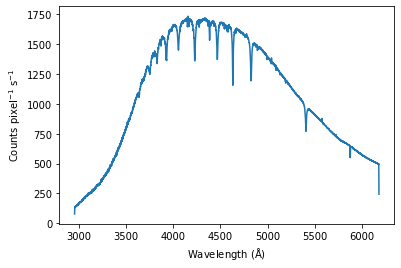

In [3]:
data_counts = data[:, 625:690].sum(axis=1)
data_wavelengths = comp_2_pix_to_wavelength(np.arange(data.shape[0]))
data_wavelengths = np.flip(data_wavelengths)
data_counts /= (6 * 60)  # convert to counts per second
data_counts = np.flip(data_counts)

# plot the observed spectrum
plt.plot(data_wavelengths, data_counts)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Counts $\mathregular{pixel^{-1}\ s^{-1}}$')
plt.savefig('data_counts.png', dpi=300)
# print(data_wavelengths[1]-data_wavelengths[0])

Text(0, 0.5, 'Flux density (erg $\\mathregular{cm^{-2}\\ s^{-1}\\ \\AA^{-1}}$)')

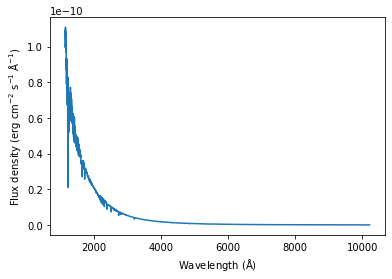

In [4]:
standard_data = Table.read('bd_75d325_stis_001.dat', format='ascii')
standard_wavelength = standard_data['col1']
standard_flux = standard_data['col2']
plt.plot(standard_wavelength, standard_flux)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux density (erg $\mathregular{cm^{-2}\ s^{-1}\ \AA^{-1}}$)')

In [35]:
# find all the points in standard_wavelength that are greater than the minimum of data_wavelengths and less than the maximum of data_wavelengths
ii = [i for i in range(len(standard_wavelength)) if
      float(np.amin(data_wavelengths)) < standard_wavelength[i] < float(np.amax(data_wavelengths))]

# Make new flux spectrum wavelength arrays for the range of wavelengths in data_wavelengths
standard_wavelength_trimmed = standard_wavelength[ii]

# Use spectres to resample the data onto the flux spectrum wavelength scale
data_counts_masked = spectres(standard_wavelength_trimmed, data_wavelengths, data_counts, fill=1)

# Create the flux factor: divide the true flux spectrum by the observed spectrum
flux_factor = standard_flux[ii] / data_counts_masked

# Interpolate the flux factor onto the data_wavelengths
flux_factor_interp = interp1d(standard_wavelength_trimmed, flux_factor, kind='cubic', fill_value='extrapolate')
flux_factor_data = flux_factor_interp(data_wavelengths)

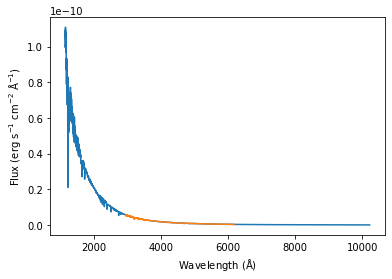

In [36]:
# Plot the flux spectrum and the data scaled by the flux factor
plt.plot(standard_wavelength, standard_flux)
plt.plot(data_wavelengths, flux_factor_data*data_counts)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$)')
plt.savefig('standard_star_with_data_scaled.png', dpi=300)

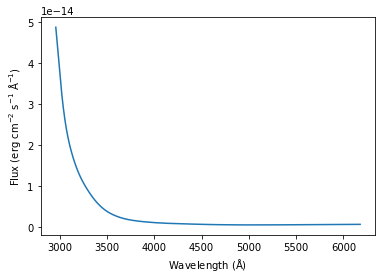

In [37]:
# Smoothing!
kwid = 64
flux_factor_data_smooth = convolve(flux_factor_data, Gaussian1DKernel(kwid), boundary='extend')
plt.plot(data_wavelengths, flux_factor_data_smooth)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.savefig('plots/bd_flux_1_smooth.png', dpi=300)

In [38]:
# get the median value of the smoothed flux factor between wavelengths 4000 and 6000
flux_factor_data_smooth = np.median(flux_factor_data_smooth[(su_aur_wavelengths > 4000) & (su_aur_wavelengths < 6000)])

In [39]:
# multiply the flux factor by the data
su_aur = fits.open('apo_files/0032.SUAur.fits')[0].data
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# ax.imshow(su_aur, cmap='gray', vmin=0, vmax=1e4)
# ax.set_xlim(925, 1000)

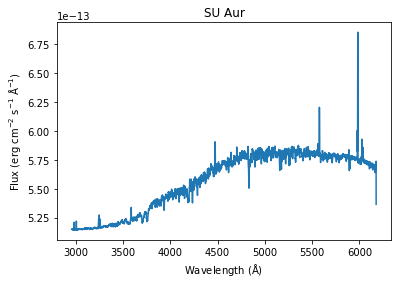

In [40]:
su_aur_counts = su_aur[:, 925:1000].sum(axis=1)
su_aur_wavelengths = comp_2_pix_to_wavelength(np.arange(su_aur.shape[0]))
su_aur_wavelengths = np.flip(su_aur_wavelengths)
# plt.plot(su_aur_wavelengths, np.flip(su_aur_counts))

su_aur_counts = su_aur_counts / (5 * 60)  # convert to counts per second
su_aur_counts = np.flip(su_aur_counts)
su_aur_flux = flux_factor_data_smooth * su_aur_counts
plt.plot(su_aur_wavelengths, su_aur_flux)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('SU Aur')
plt.savefig('plots/su_aur_flux.png', dpi=300)

In [41]:
# multiply the flux factor by the data
dr_tau = fits.open('ccd_calibrations/drtau.fits')[0].data
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# ax.imshow(dr_tau, cmap='gray', vmin=0, vmax=1e3)
# ax.set_xlim(625, 700)

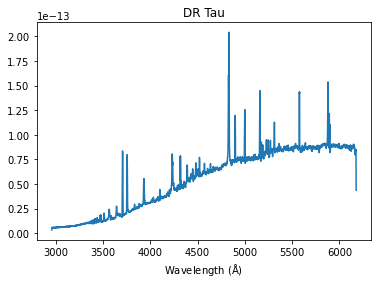

In [42]:
dr_tau_counts = dr_tau[:, 625:700].sum(axis=1)
dr_tau_wavelengths = comp_2_pix_to_wavelength(np.arange(dr_tau.shape[0]))
dr_tau_wavelengths = np.flip(dr_tau_wavelengths)
dr_tau_counts /= (5 * 60)  # convert to counts per second
dr_tau_counts = np.flip(dr_tau_counts)
dr_tau_flux = flux_factor_data_smooth * dr_tau_counts
plt.plot(dr_tau_wavelengths, dr_tau_flux)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
# plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('DR Tau')
plt.savefig('plots/dr_tau_flux.png', dpi=300)

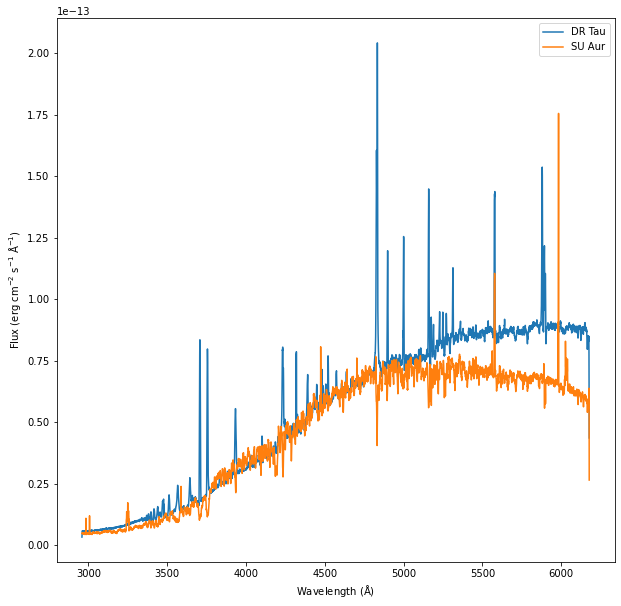

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(dr_tau_wavelengths, dr_tau_flux, label='DR Tau')
scale_factor = 5.1e-13
ax.plot(su_aur_wavelengths, su_aur_flux - scale_factor, label='SU Aur')
ax.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax.set_ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
ax.legend()
plt.savefig('plots/dr_tau_su_aur_flux.png', dpi=300)

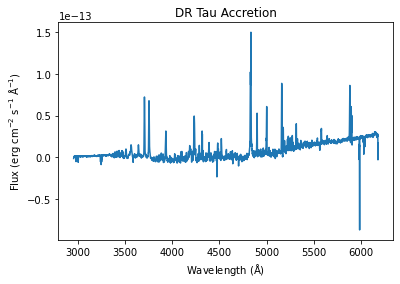

In [49]:
dr_tau_accretion = dr_tau_flux - (su_aur_flux - scale_factor)
plt.plot(dr_tau_wavelengths, dr_tau_accretion)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('DR Tau Accretion')
plt.savefig('plots/dr_tau_accretion.png', dpi=300)

In [97]:
# integrate the accretion flux
l_acc_dr_tau = np.trapz(dr_tau_accretion, dr_tau_wavelengths)
r_sun_cm = 6.957e10
m_sun_g = 1.989e33
r_dr_tau = 1.6*r_sun_cm
m_dr_tau = 9e-8 * m_sun_g
big_g_cgs = 6.67e-8
mdot_dr_tau = (5 * l_acc_dr_tau * r_dr_tau)/(4 * big_g_cgs * m_dr_tau)
seconds_per_year = 365 * 24 * 60 * 60
print(l_acc_dr_tau, mdot_dr_tau)

2.6344893089047292e-11 3.0700490415174853e-19


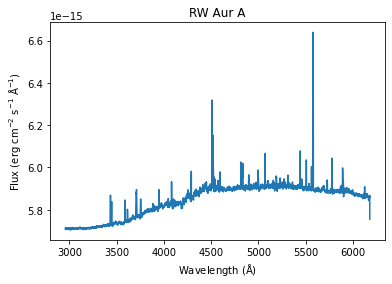

In [72]:
# multiply the flux factor by the data
rw_aur_a = fits.open('apo_files/0039.RWAur.fits')[0].data
rw_aur_a_counts = rw_aur_a[:, 900:1000].mean(axis=1)
rw_aur_a_wavelengths = comp_2_pix_to_wavelength(np.arange(rw_aur_a.shape[0]))
rw_aur_a_wavelengths = np.flip(rw_aur_a_wavelengths)
rw_aur_a_counts /= (6 * 60)  # convert to counts per second
rw_aur_a_counts = np.flip(rw_aur_a_counts)
rw_aur_a_flux = flux_factor_data_smooth * rw_aur_a_counts
plt.plot(rw_aur_a_wavelengths, rw_aur_a_flux)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('RW Aur A')
plt.savefig('plots/rw_aur_a_flux.png', dpi=300)

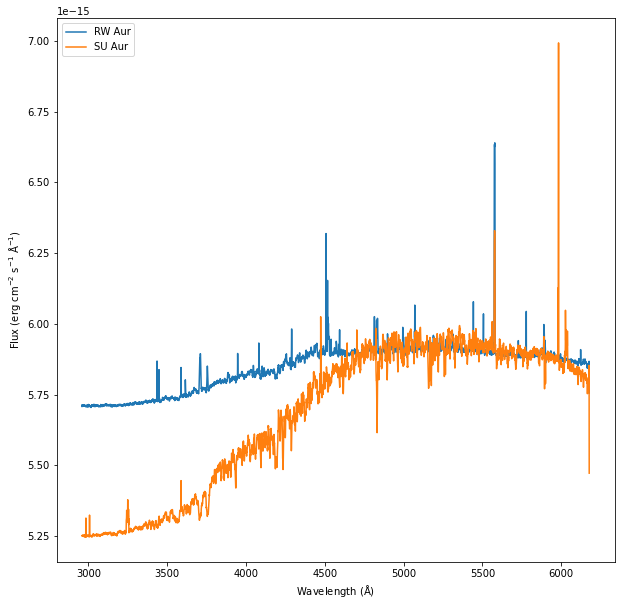

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(rw_aur_a_wavelengths, rw_aur_a_flux, label='RW Aur')
scale_factor = 0.0102
ax.plot(su_aur_wavelengths, su_aur_flux * scale_factor, label='SU Aur')
ax.set_xlabel('Wavelength ($\mathregular{\AA}$)')
ax.set_ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
ax.legend()
plt.savefig('plots/rw_aur_su_aur_flux.png', dpi=300)

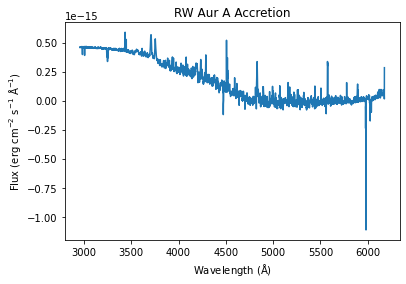

In [87]:
rw_aur_a_accretion = rw_aur_a_flux - (su_aur_flux * scale_factor)
plt.plot(rw_aur_a_wavelengths, rw_aur_a_accretion)
plt.xlabel('Wavelength ($\mathregular{\AA}$)')
plt.ylabel('Flux ($\mathregular{erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('RW Aur A Accretion')
plt.savefig('plots/rw_aur_a_accretion.png', dpi=300)

In [98]:
l_acc_rw_aur = np.trapz(rw_aur_a_accretion, rw_aur_a_wavelengths)
r_rw_aur = 1.3*6.96e10
m_rw_aur = 1.1*2e33
mdot_rw_aur = (5 * l_acc_rw_aur * r_rw_aur)/(4 * big_g_cgs * m_rw_aur)

In [100]:
print(l_acc_rw_aur, mdot_rw_aur)

5.430310195972502e-13 4.185416949464973e-28
